找到 10 个文件，开始分析...
检测到变化的超参数: ['MAX_SAMPLES', 'Output_dimensions', 'CHANNELS']
对比图已保存为: hyperparameters_comparison.pdf.pdf


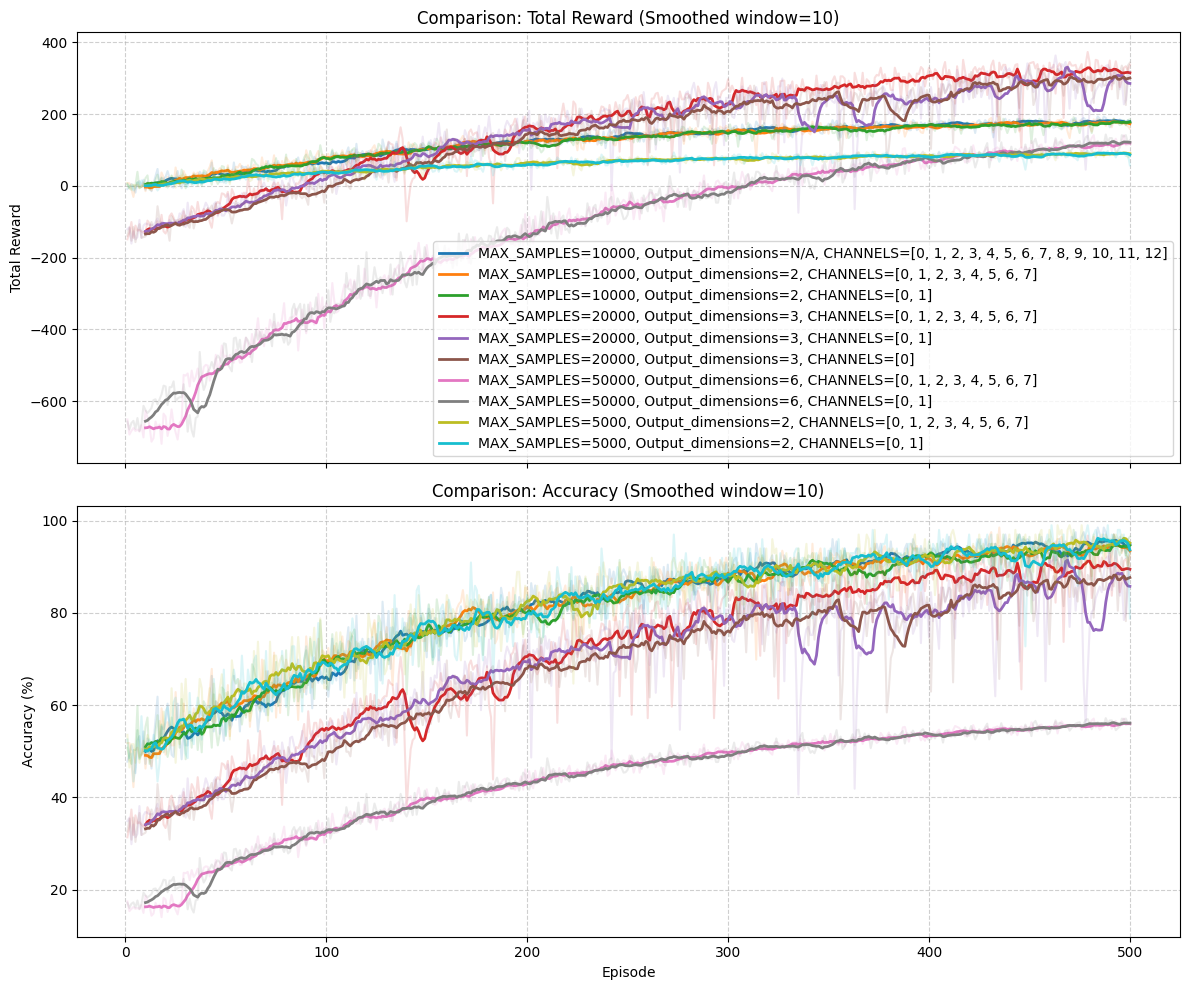

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

def parse_log_file(filepath):
    """
    读取特定的日志CSV文件，分离超参数和训练数据。
    修复版：可以正确读取包含逗号的列表参数（如CHANNELS）。
    """
    params = {}
    data_start_line = 0
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            
        for i, line in enumerate(lines):
            line = line.strip()
            # 找到数据区的起始标记
            if "--- Training Data ---" in line:
                data_start_line = i + 1
                break
            
            # --- 修复核心：更稳健的解析逻辑 ---
            # 排除空行和标题行
            if ',' in line and "---" not in line and line:
                # 方法：只分割第一个逗号，后面的内容（即使有逗号）都算作 value
                parts = line.split(',', 1) 
                
                if len(parts) >= 2:
                    key = parts[0].strip()
                    value = parts[1].strip()
                    
                    # 去除 CSV 可能自动添加的引号
                    if value.startswith('"') and value.endswith('"'):
                        value = value[1:-1]
                        
                    params[key] = value
                    
        # 读取训练数据部分
        df = pd.read_csv(filepath, skiprows=data_start_line)
        return params, df
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None, None

def plot_comparison(folder_path='.', smoothing_window=10):
    """
    对比文件夹内所有CSV文件并绘图
    """
    # 获取所有csv文件
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    if not csv_files:
        print(f"在 '{folder_path}' 中没有找到 .csv 文件。")
        return

    print(f"找到 {len(csv_files)} 个文件，开始分析...")
    
    experiments = [] # 存储所有实验数据: {'filename':..., 'params':..., 'df':...}

    # --- 第一步：加载所有数据 ---
    for f in csv_files:
        params, df = parse_log_file(f)
        if df is not None and not df.empty:
            experiments.append({
                'filename': os.path.basename(f),
                'params': params,
                'df': df
            })
    
    if not experiments:
        print("没有读取到有效的实验数据。")
        return

    # --- 第二步：找出不同的超参数 ---
    # 获取所有出现过的超参数 Key
    all_keys = set()
    for exp in experiments:
        all_keys.update(exp['params'].keys())
    
    # 筛选出在不同文件中值不一样的 Key
    diff_keys = []
    for key in all_keys:
        values = set(exp['params'].get(key, 'N/A') for exp in experiments)
        if len(values) > 1: # 如果同一个Key有超过1种的值，说明它是变量
            diff_keys.append(key)
            
    print(f"检测到变化的超参数: {diff_keys}")

    # --- 第三步：绘图 ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # 使用不同的颜色循环
    colors = plt.cm.tab10.colors 
    
    for i, exp in enumerate(experiments):
        df = exp['df']
        params = exp['params']
        
        # 1. 生成图例标签 (Legend Label)
        if diff_keys:
            # 只显示不同的参数，例如 "BATCH_SIZE=64, LR=0.01"
            label_parts = [f"{k}={params.get(k, 'N/A')}" for k in diff_keys]
            label = ", ".join(label_parts)
        else:
            # 如果参数全一样（比如多次运行），就用文件名
            label = exp['filename']
            
        color = colors[i % len(colors)]
        
        # 2. 绘制 Total Reward
        # 原始数据（透明度高，作为背景）
        ax1.plot(df['Episode'], df['Total Reward'], color=color, alpha=0.15)
        # 平滑数据（实线，作为主展示）
        if len(df) > smoothing_window:
            smoothed = df['Total Reward'].rolling(window=smoothing_window).mean()
            ax1.plot(df['Episode'], smoothed, color=color, label=label, linewidth=2)
        else:
            ax1.plot(df['Episode'], df['Total Reward'], color=color, label=label, linewidth=2)

        # 3. 绘制 Accuracy
        # 原始数据
        ax2.plot(df['Episode'], df['Accuracy (%)'], color=color, alpha=0.15)
        # 平滑数据
        if len(df) > smoothing_window:
            smoothed_acc = df['Accuracy (%)'].rolling(window=smoothing_window).mean()
            ax2.plot(df['Episode'], smoothed_acc, color=color, label=label, linewidth=2)
        else:
            ax2.plot(df['Episode'], df['Accuracy (%)'], color=color, label=label, linewidth=2)

    # --- 设置图表样式 ---
    ax1.set_title(f'Comparison: Total Reward (Smoothed window={smoothing_window})')
    ax1.set_ylabel('Total Reward')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend()

    ax2.set_title(f'Comparison: Accuracy (Smoothed window={smoothing_window})')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_xlabel('Episode')
    ax2.grid(True, linestyle='--', alpha=0.6)
    # ax2.legend() # 如果图例太多，可以只在第一张图显示

    plt.tight_layout()
    
    # 保存结果
    output_filename = 'hyperparameters_comparison.pdf'
    plt.savefig(output_filename, dpi=300)
    print(f"对比图已保存为: {output_filename}.pdf")
    plt.show()

# --- 运行脚本 ---
# 修改这里为你的csv文件夹路径，如果是当前文件夹则用 '.'
if __name__ == "__main__":
    plot_comparison(folder_path='.') # 假设你的csv在data文件夹里